# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 10.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 17.8 MB/s eta 0:00:00


In [21]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [4]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/nf/fh2jz2v91d74c61pnzkmr98m0000gp/T/ipykernel_83747/1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [6]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


In [9]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Plot the search interest for May 2020
df_may_2020.plot(figsize=(14, 6), title='Google Search Traffic for MercadoLibre - May 2020')


<Axes: title={'center': 'Google Search Traffic for MercadoLibre - May 2020'}, xlabel='Date'>

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [11]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
traffic_may_2020

np.int64(38181)

In [13]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
monthly_traffic = df_mercado_trends['Search Trends'].resample('ME').sum()
median_monthly_traffic = monthly_traffic.median()

# View the median_monthly_traffic value
median_monthly_traffic

35172.5

In [14]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

np.float64(1.0855355746677091)

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes it did, google search traffic grew during may 2020 by 8.55% than the median 

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

In [16]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Group by hour of day and plot average search traffic
hourly_avg = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()
hourly_avg.index = range(24)  # Ensure the x-axis is clean (0–23)
hourly_avg.plot(kind='bar', figsize=(12, 5), title='Average Search Traffic by Hour of Day', xlabel='Hour of Day', ylabel='Avg Search Traffic')


<Axes: title={'center': 'Average Search Traffic by Hour of Day'}, xlabel='Hour of Day', ylabel='Avg Search Traffic'>

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

In [17]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
dow_avg = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()
dow_avg.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_avg.plot(kind='bar', figsize=(10, 5), title='Average Search Traffic by Day of Week', xlabel='Day', ylabel='Avg Search Traffic')

<Axes: title={'center': 'Average Search Traffic by Day of Week'}, xlabel='Day', ylabel='Avg Search Traffic'>

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

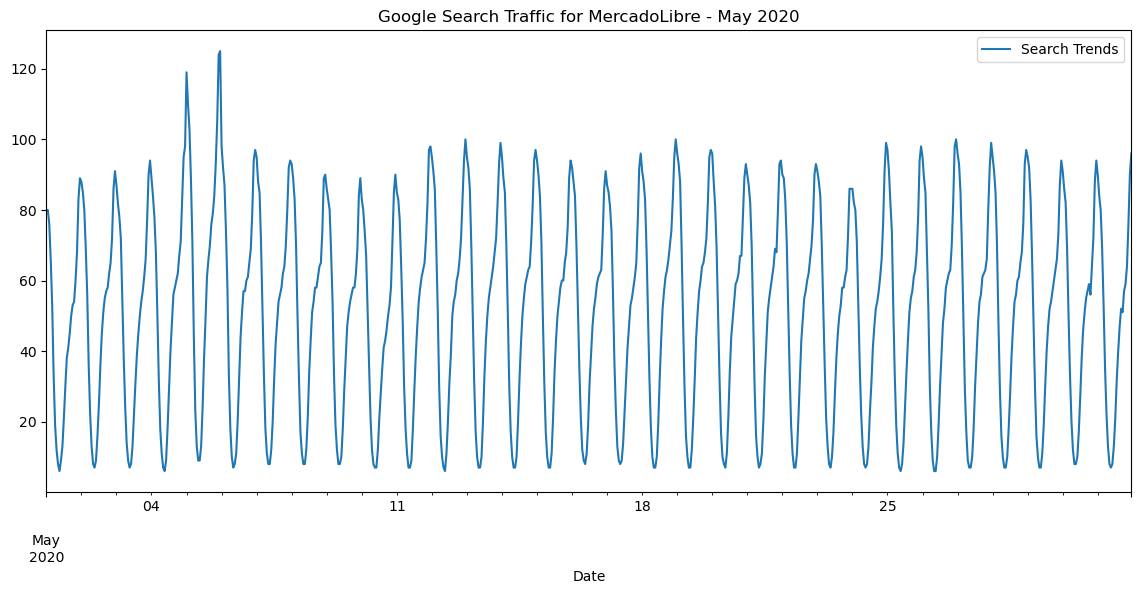

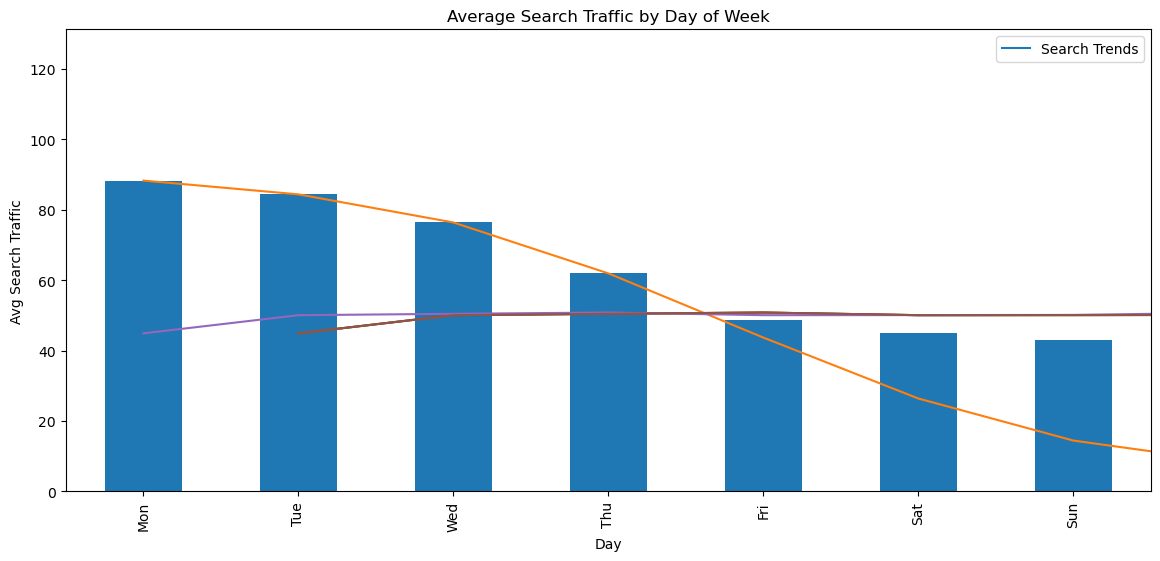

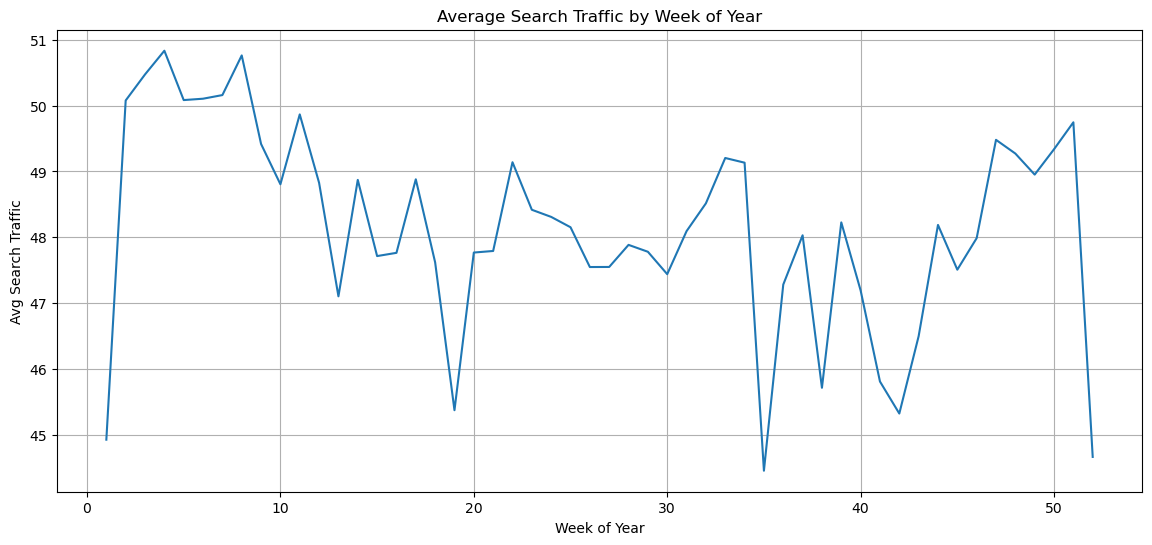

In [24]:
# Group by week of year and reset index for safe plotting
weekly_data = df_mercado_trends.copy()
weekly_data['Week'] = df_mercado_trends.index.isocalendar().week
weekly_avg = weekly_data.groupby('Week')['Search Trends'].mean()

plt.figure(figsize=(14, 6))
plt.plot(weekly_avg.index.astype(int), weekly_avg.values)
plt.title('Average Search Traffic by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Avg Search Traffic')
plt.grid(True)
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** There is a consistent daily pattern with sharp peaks showing strong hourly seasonality. 

The search activity is highest on Mondays with a decline through the week

ecommerce interest shows rise in search traffic.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [25]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


In [26]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_mercado_stock['close'].plot(figsize=(14, 6), title='MercadoLibre Hourly Closing Stock Price', xlabel='Date', ylabel='Stock Price (USD)')

<Axes: title={'center': 'MercadoLibre Hourly Closing Stock Price'}, xlabel='Date', ylabel='Stock Price (USD)'>

In [27]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_merged = pd.concat([df_mercado_trends, df_mercado_stock], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(df_merged.head())
display(df_merged.tail())

,Search Trends,close
2016-06-01 09:00:00,6.0,135.16
2016-06-01 10:00:00,12.0,136.63
2016-06-01 11:00:00,22.0,136.56
2016-06-01 12:00:00,33.0,136.42
2016-06-01 13:00:00,40.0,136.10


,Search Trends,close
2020-07-31 11:00:00,20.0,1105.780
2020-07-31 12:00:00,32.0,1087.925
2020-07-31 13:00:00,41.0,1095.800
2020-07-31 14:00:00,47.0,1110.650
2020-07-31 15:00:00,53.0,1122.510


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [28]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_merged.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,Search Trends,close
2020-01-02 09:00:00,9.0,601.085
2020-01-02 10:00:00,14.0,601.290
2020-01-02 11:00:00,25.0,615.410
2020-01-02 12:00:00,37.0,611.400
2020-01-02 13:00:00,50.0,611.830


,Search Trends,close
2020-06-30 11:00:00,17.0,976.17
2020-06-30 12:00:00,27.0,977.50
2020-06-30 13:00:00,37.0,973.23
2020-06-30 14:00:00,45.0,976.50
2020-06-30 15:00:00,51.0,984.93


In [30]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
first_half_2020[['close', 'Search Trends']].plot(subplots=True, figsize=(14, 8), title='Search Trends vs. Stock Price (Jan–Jun 2020)')


array([<Axes: >, <Axes: >], dtype=object)

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Yes both time series show a trend that aligns with this narrative

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [32]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
first_half_2020.loc[:, 'Lagged Search Trends'] = first_half_2020['Search Trends'].shift(1)


In [34]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
first_half_2020.loc[:, 'Stock Volatility'] = first_half_2020['Hourly Stock Return'].ewm(span=4).std()


In [36]:
# Visualize the stock volatility
first_half_2020['Stock Volatility'].plot(figsize=(14, 6), title='MercadoLibre Hourly Stock Volatility (Jan–Jun 2020)', xlabel='Date', ylabel='Volatility')


<Axes: title={'center': 'MercadoLibre Hourly Stock Volatility (Jan–Jun 2020)'}, xlabel='Date', ylabel='Volatility'>

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [37]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
first_half_2020.loc[:, 'Hourly Stock Return'] = first_half_2020['close'].pct_change()


In [38]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,Search Trends,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
2020-01-02 09:00:00,9.0,601.085,NaN,NaN,NaN
2020-01-02 10:00:00,14.0,601.290,9.0,0.000341,NaN
2020-01-02 11:00:00,25.0,615.410,14.0,0.023483,0.016364
2020-01-02 12:00:00,37.0,611.400,25.0,-0.006516,0.016910
2020-01-02 13:00:00,50.0,611.830,37.0,0.000703,0.011995


,Search Trends,close,Lagged Search Trends,Hourly Stock Return,Stock Volatility
2020-06-30 11:00:00,17.0,976.17,11.0,-0.002656,0.004350
2020-06-30 12:00:00,27.0,977.50,17.0,0.001362,0.003799
2020-06-30 13:00:00,37.0,973.23,27.0,-0.004368,0.003668
2020-06-30 14:00:00,45.0,976.50,37.0,0.003360,0.004174
2020-06-30 15:00:00,51.0,984.93,45.0,0.008633,0.005802


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [40]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
first_half_2020[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.044662,0.035098
Lagged Search Trends,-0.044662,1.000000,-0.003399
Hourly Stock Return,0.035098,-0.003399,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** There doesn't seem to be a strong or predictable relatioship between the lagged search and either stock volalitiy or houlry returns.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [41]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()
# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df = mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [42]:
# Call the Prophet function, store as an object
model = Prophet()

In [43]:
# Fit the time-series model.
model.fit(mercado_prophet_df)

20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:25:15 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail()

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [46]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.275375,81.619883,97.798810,44.275375,44.275375,45.309572,45.309572,45.309572,41.452721,...,1.860328,1.860328,1.860328,1.996523,1.996523,1.996523,0.0,0.0,0.0,89.584947
1,2016-06-01 01:00:00,44.276378,77.780191,93.609069,44.276378,44.276378,41.755341,41.755341,41.755341,37.943520,...,1.810240,1.810240,1.810240,2.001582,2.001582,2.001582,0.0,0.0,0.0,86.031720
2,2016-06-01 02:00:00,44.277382,67.647546,83.981392,44.277382,44.277382,31.431828,31.431828,31.431828,27.656558,...,1.768661,1.768661,1.768661,2.006609,2.006609,2.006609,0.0,0.0,0.0,75.709210
3,2016-06-01 03:00:00,44.278385,52.016556,68.486851,44.278385,44.278385,16.164591,16.164591,16.164591,12.417303,...,1.735683,1.735683,1.735683,2.011605,2.011605,2.011605,0.0,0.0,0.0,60.442977
4,2016-06-01 04:00:00,44.279389,35.251969,51.852996,44.279389,44.279389,-0.950297,-0.950297,-0.950297,-4.678130,...,1.711263,1.711263,1.711263,2.016569,2.016569,2.016569,0.0,0.0,0.0,43.329091


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

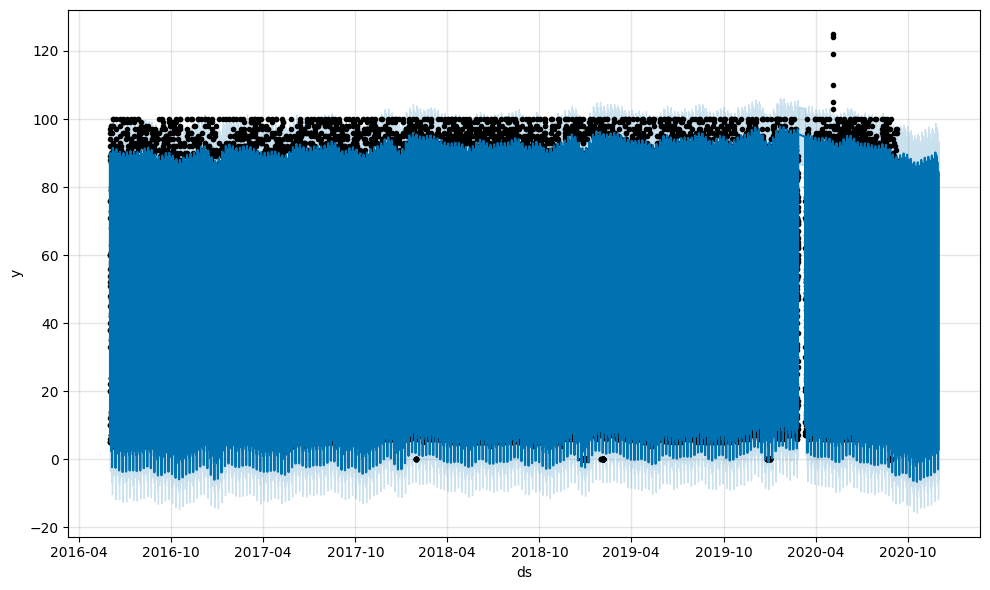

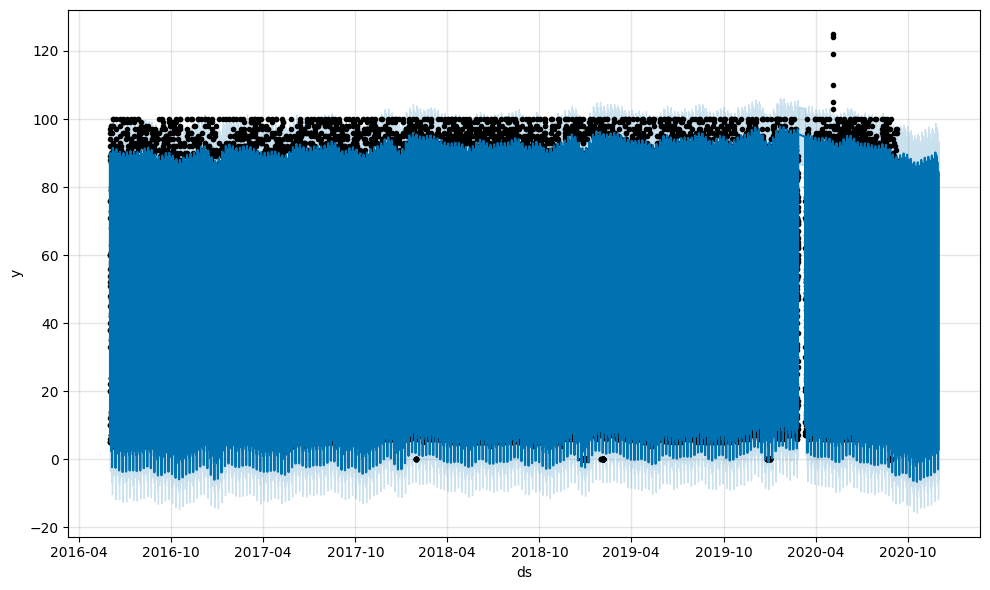

In [ ]:
# Plot the Prophet predictions for the Mercado trends data
forecast = model.predict(future_mercado_trends)
model.plot(forecast)

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**  the forecast for the popularity of mercadolibre appears to be pretty stable, with some fluctuatuions that align with some seasonal patterns.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [47]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast.set_index('ds', inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast[['yhat', 'yhat_lower', 'yhat_upper']].head()


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.584947,81.619883,97.798810
2016-06-01 01:00:00,86.031720,77.780191,93.609069
2016-06-01 02:00:00,75.709210,67.647546,83.981392
2016-06-01 03:00:00,60.442977,52.016556,68.486851
2016-06-01 04:00:00,43.329091,35.251969,51.852996


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

In [48]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail(2000).plot(figsize=(14, 6), title='Forecasted Search Trends - Last 2000 Hours')

<Axes: title={'center': 'Forecasted Search Trends - Last 2000 Hours'}, xlabel='ds'>

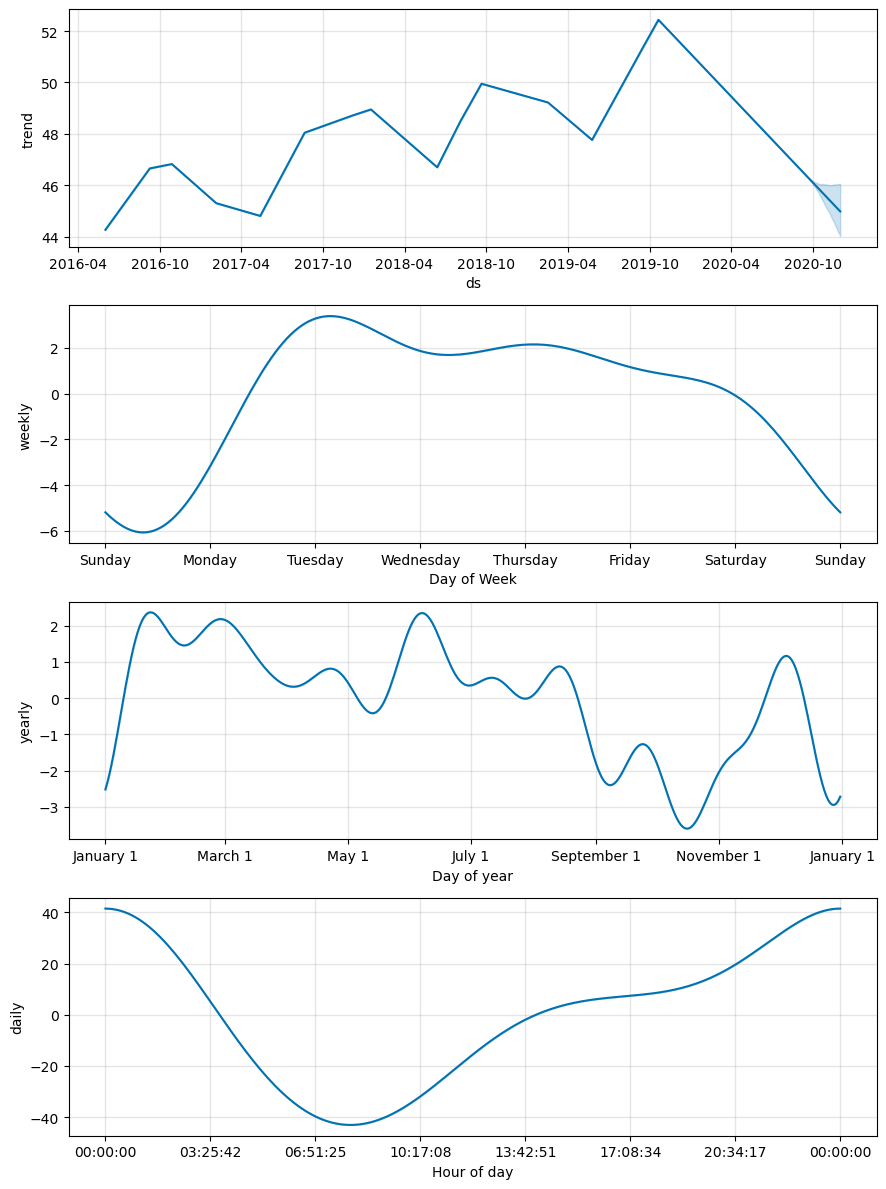

In [49]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
model.plot_components(forecast)

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** highest search traffic is around midnight

**Question:** Which day of week gets the most search traffic?
   
**Answer:**  Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**  Late December.
